# Community Detection
In this session we shall use a community detection algorithm to discover large community of similar nodes in the graph we constructed in the earlier session "Finding pairwise dissimilarity from Siamese Network".

## Imports

In [0]:
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import PIL.ImageOps    
from PIL import Image
import numpy as np
import itertools
import math
import sys
import os

## Helper functions

In [0]:
# Creates a NetworkX graph object
def make_graph(sim, labels=None):
    G = nx.Graph()
    for i in range(sim.shape[0]):
        for j in range(sim.shape[1]):
            if i != j and sim[i,j] != 0:
                if labels == None:
                    G.add_edge(i, j, weight=sim[i,j])
                else:
                    G.add_edge(labels[i], labels[j], weight=sim[i,j])
    return G

# Generate edges for Gephi or pals  
def export_edge_list(sim, labels=None, filename="edges.csv", delim=",", header=True):
    f = open(savedir + filename, 'w')
    if header:
        f.write("Source,Target\n")
    loc = np.where(sim > 0)
    for (i, j) in [(i, j) for (i, j) in zip(loc[0], loc[1]) if i < j]:
        if labels == None:
            f.write(str(i) + delim + str(j) + "\n")
        else:
            f.write("\"" + labels[i] + "\"" + delim + "\"" + labels[j] + "\"\n")                          
    f.close()

##Configuration

In [0]:
class Config():
    colors = ['aquamarine', 'bisque', 'blanchedalmond', 'blueviolet', 'brown',
              'burlywood', 'cadetblue', 'chartreuse','chocolate', 'coral',
              'cornflowerblue', 'cornsilk', 'crimson', 'darkblue', 'darkcyan',
              'darkgoldenrod', 'darkgray', 'darkgreen', 'darkgrey', 'darkkhaki',
              'darkmagenta', 'darkolivegreen', 'darkorange', 'darkslateblue',
              'darkorchid', 'darkred', 'darksalmon', 'darkseagreen',
              'darkslategray', 'darkslategrey', 'darkturquoise', 'darkviolet',
              'deeppink', 'deepskyblue', 'dimgray', 'dimgrey', 'dodgerblue',
              'firebrick', 'floralwhite', 'forestgreen', 'fuchsia', 'gainsboro',
              'ghostwhite', 'gold', 'goldenrod', 'gray', 'green', 'greenyellow',
              'grey', 'honeydew', 'hotpink', 'indianred', 'indigo', 'ivory']

## Give access to Google Drive

In [5]:
savedir = ""
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/gdrive')
    savedir = "/content/gdrive/My Drive/colab/"
    try:
        os.mkdir(savedir)
    except FileExistsError:
        print("Directory \"%s\" already exists" % (savedir))

print("Content of {}:".format(savedir))
os.listdir(savedir)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Directory "/content/gdrive/My Drive/colab/" already exists
Content of /content/gdrive/My Drive/colab/:


['dissim.tsv',
 'labels.txt',
 'siamese.0.pth',
 'siamese.2.pth',
 'siamese.4.pth',
 'siamese.6.pth',
 'siamese.8.pth',
 'siamese.10.pth',
 'siamese.12.pth',
 'siamese.14.pth',
 'siamese.16.pth',
 'siamese.18.pth',
 'siamese.20.pth',
 'siamese.22.pth',
 'siamese.24.pth',
 'sim.txt',
 'gephi-edges.csv',
 'pals-edges.txt',
 'pals-community.txt']

## Build graph
Construct an adjacency matrix from the dissimilarity matrix, then use the adjacency matrix to build a networkx graph


In [6]:
# Loads the dissimilarity matrix (and node labels)

sim = np.loadtxt(savedir + 'sim.txt')
labels = list(np.genfromtxt(savedir + 'labels.txt', dtype='str'))

print("Restored %dx%d matrix" % (sim.shape[0], sim.shape[1]))
print("Labels of elements:", labels)

Restored 18x18 matrix
Labels of elements: ['s1', 's10', 's11', 's14', 's18', 's21', 's25', 's26', 's27', 's28', 's29', 's30', 's31', 's34', 's37', 's40', 's41', 's8']


diagonal avg=155.41 min=95.05 max=242.81


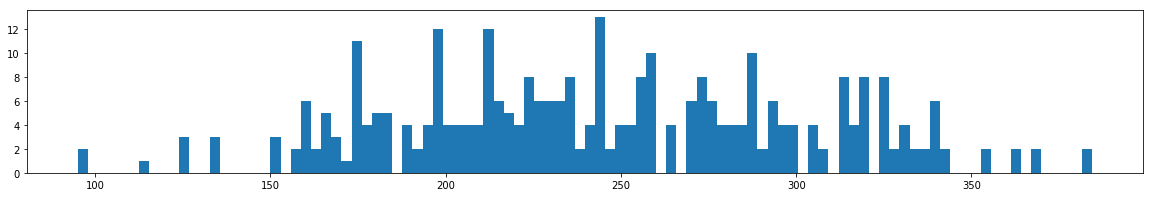

In [7]:
# Analyze distribution of dissimilarity score

d = np.diagonal(sim)
print('diagonal avg=%.2f min=%.2f max=%.2f' % (np.mean(d), np.min(d), np.max(d)))
simflat = sim.reshape((-1,))
plt.rcParams["figure.figsize"] = (20,3)
_ = plt.hist(simflat, bins=100)
plt.show()

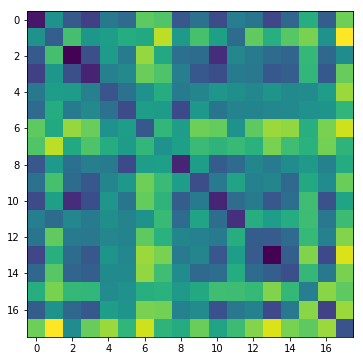

In [10]:
# View an image representation of the distance matrix

plt.figure(figsize=(6,6))
plt.imshow(sim)
plt.show()

In [11]:
# Select a suitable threshold and set dissimilarity scores larger than that threshold to zero

threshold = 200
adjmat = sim.reshape((-1,)).copy()
adjmat[adjmat > threshold] = 0
#adjmat[adjmat > 0] = 1
print("{} out of {} values set to zero".format(len(adjmat[adjmat == 0]), len(adjmat)))
adjmat = adjmat.reshape(sim.shape)

244 out of 324 values set to zero


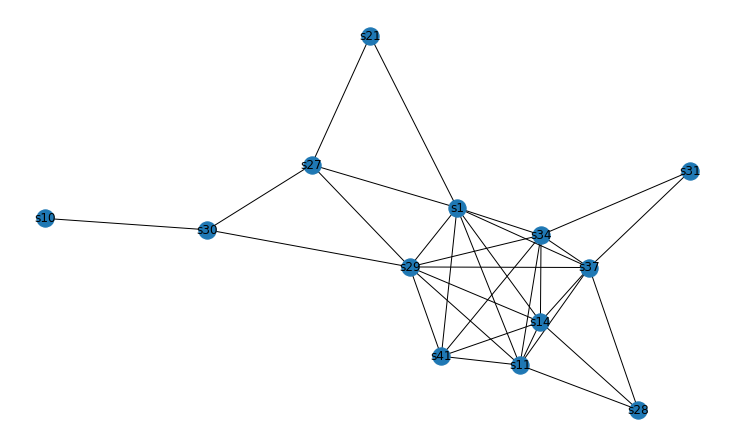

In [12]:
# Construct a networkx graph from the adjacency matrix
# (Singleton nodes are excluded from the graph)

G = make_graph(adjmat, labels=labels)
plt.rcParams["figure.figsize"] = (10, 6)
nx.draw(G, with_labels=True)

##Community detection using Girvan-Newman

Possible clusters 1 : ({'s1', 's31', 's21', 's27', 's34', 's37', 's14', 's29', 's28', 's41', 's11'}, {'s10', 's30'})


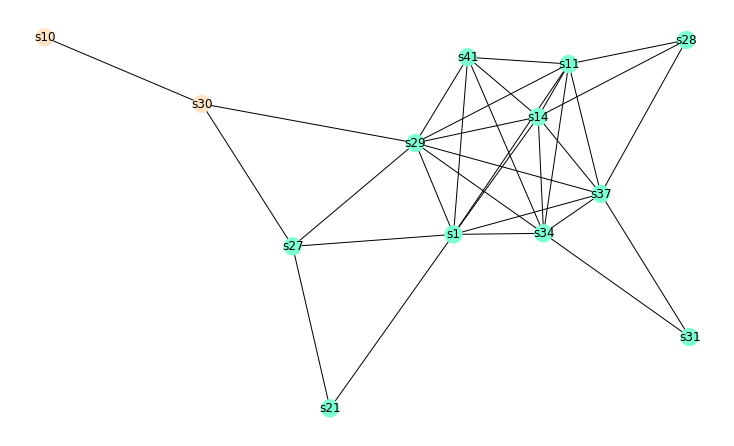

Possible clusters 2 : ({'s1', 's31', 's27', 's34', 's37', 's14', 's29', 's28', 's41', 's11'}, {'s21'}, {'s10', 's30'})


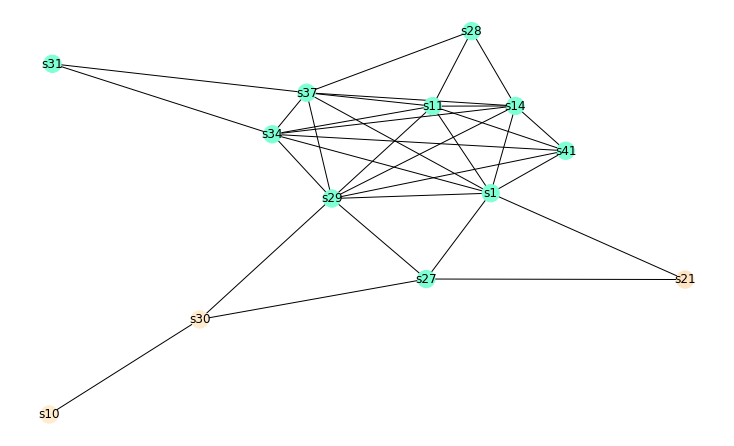

Possible clusters 3 : ({'s1', 's31', 's34', 's37', 's14', 's29', 's28', 's41', 's11'}, {'s21'}, {'s27'}, {'s10', 's30'})


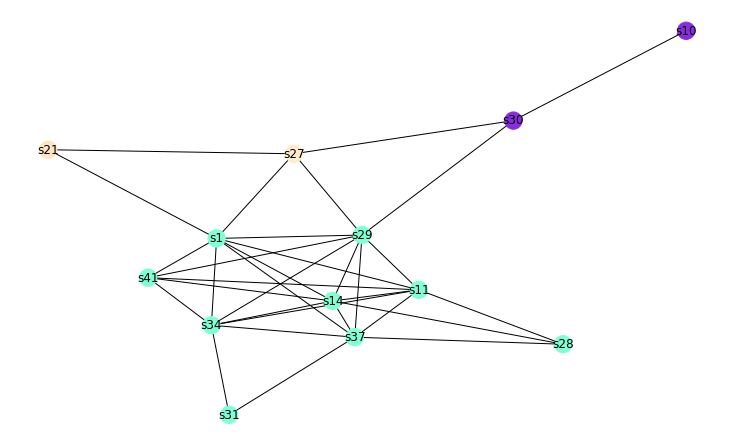

In [14]:
from networkx.algorithms.community.centrality import girvan_newman

comp = girvan_newman(G)

max_shown = 3
shown_count = 1
possibilities = []
for communities in itertools.islice(comp, max_shown):
    print("Possible clusters", shown_count, ": ", end='')
    print(communities)
    possibilities.append(communities)
    color_map = ["" for x in range(len(G))]
    color = 0
    for c in communities:
        indices = [i for i, x in enumerate(G.nodes) if x in c]
        for i in indices:
            color_map[i] = Config.colors[color]
        color += 1
    shown_count += 1
    nx.draw(G, node_color=color_map, with_labels=True)
    plt.show()


##Visualization

###Gephi
Gephi Download - https://gephi.org/users/download/<br>
Gephi HOWTO    - https://gephi.wordpress.com/2017/09/26/gephi-0-9-2-a-new-csv-importer/<br>
*(It is possible to colorize communities in Gephi - read here: https://github.com/kalngyk/repoman/raw/master/gephi_communities.pdf)*


In [0]:
# Generate edges for Gephi

export_edge_list(adjmat, labels=labels, filename='gephi-edges.csv')

###pals
pals HOWTO - https://github.com/kalngyk/repoman/raw/master/usepals.pdf


In [0]:
# Generate edges for pals system

export_edge_list(adjmat, labels=labels, filename='pals-edges.txt', delim=" ", header=False)

In [0]:
# Generate community file for pals system

which_possibility = 3

communities = possibilities[which_possibility-1]

f = open(savedir + 'pals-community.txt', 'w')
cur_com = 1
for c in communities:
    indices = [i for i, x in enumerate(G.nodes) if x in c]
    for i in indices:
        if labels == None:
            f.write(str(i) + " " + str(cur_com) + "\n")
        else:
            f.write("\"" + labels[i] + "\" " + str(cur_com) + "\n")
    cur_com += 1
f.close()

os.listdir(savedir)

['labels.txt',
 'siamese.0.pth',
 'siamese.2.pth',
 'siamese.4.pth',
 'siamese.6.pth',
 'siamese.8.pth',
 'siamese.10.pth',
 'siamese.12.pth',
 'siamese.14.pth',
 'siamese.16.pth',
 'siamese.18.pth',
 'siamese.20.pth',
 'siamese.22.pth',
 'siamese.24.pth',
 'sim.txt',
 'dissim.tsv',
 'pals-edges.txt',
 'pals-community.txt',
 'gephi-edges.csv']